<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9,weight_decay=0.00005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [8]:
num_epochs = 70
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    scheduler.step()
torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')

Epoch 1: Loss: 2.1124, Train Accuracy: 25.06%
Test Accuracy: 48.90%
Confusion Matrix (Epoch 1):
[[594  37  64  18  15   4   5  16 215  32]
 [ 60 622  36  18   7  20  15  18  73 131]
 [110  33 487  53 101  47  93  41  26   9]
 [ 52  43 135 322  42 207  67  79  27  26]
 [ 70  16 114  61 338  36 169 164  24   8]
 [ 29  25 121 125  50 476  38 112  11  13]
 [ 35  28 132  82  82  52 519  39  18  13]
 [ 55  26  87  57  61  89  29 531  23  42]
 [185  83  29   4  11   7   8   9 621  43]
 [ 87 285  17  18   7  16  15  25 150 380]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 1.6664, Train Accuracy: 47.58%
Test Accuracy: 62.58%
Confusion Matrix (Epoch 2):
[[764  25  56   5   4   1   4  11 105  25]
 [ 45 777   8  14   1   7   7   7  30 104]
 [122  12 592  32  74  36  82  36   8   6]
 [ 28  22 151 384  40 224  61  57  11  22]
 [ 62   4 137  46 431  32 110 160  13   5]
 [ 12   8 113  91  29 633  22  78   4  10]
 [ 13  14 127  46  38  35 707  12   4   4]
 [ 27   7  71  37  43  62   9 721   6  17]
 [233  61  23   5   4   2   4   6 626  36]
 [ 71 202   9   7   0   3   8  13  64 623]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 1.4482, Train Accuracy: 57.56%
Test Accuracy: 68.44%
Confusion Matrix (Epoch 3):
[[805  14  41   6   9   3   3  17  84  18]
 [ 34 804   3  10   2   9   7   4  42  85]
 [ 87   5 642  38  75  38  78  28   6   3]
 [ 20  14 124 463  41 204  65  45  10  14]
 [ 44   3 104  39 544  34  68 151   8   5]
 [  9   3  71 112  48 661  18  68   4   6]
 [  7   9  84  46  36  22 778  10   5   3]
 [ 26   4  36  27  44  63   5 783   3   9]
 [238  40  16   9   5   3   4   5 662  18]
 [ 56 143   4   9   3   5   9  11  58 702]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 1.3354, Train Accuracy: 62.63%
Test Accuracy: 73.30%
Confusion Matrix (Epoch 4):
[[806  15  35   5   8   3   5  12  92  19]
 [ 22 857   1   4   3   7   8   4  22  72]
 [ 79   3 674  36  75  38  67  20   5   3]
 [ 18  10 102 517  43 211  53  29   7  10]
 [ 41   1  87  31 622  40  60 105   9   4]
 [ 11   1  51 113  40 713  19  46   3   3]
 [  4   5  67  36  29  21 825   7   5   1]
 [ 21   5  29  25  50  64   7 788   3   8]
 [140  34  10   7   4   3   1   2 780  19]
 [ 42 121   2   4   3   5   7  12  56 748]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 1.2605, Train Accuracy: 66.47%
Test Accuracy: 75.41%
Confusion Matrix (Epoch 5):
[[825  12  26   6   8   1   4  10  91  17]
 [ 21 879   2   3   2   5  11   3  19  55]
 [ 65   1 719  28  61  26  70  23   4   3]
 [ 19   7 107 542  42 175  59  30   7  12]
 [ 30   1  94  48 638  26  61  93   6   3]
 [ 12   0  53 124  32 706  21  47   2   3]
 [  7   2  60  32  14  13 862   6   4   0]
 [ 23   2  28  24  44  54   9 806   3   7]
 [122  35  11   8   4   2   2   2 806   8]
 [ 40 117   3   6   2   2   8   8  56 758]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 1.2081, Train Accuracy: 68.73%
Test Accuracy: 77.67%
Confusion Matrix (Epoch 6):
[[817  15  38   5  13   3   5   9  76  19]
 [ 13 902   2   2   1   5   8   2  17  48]
 [ 54   0 746  19  62  35  57  18   5   4]
 [ 15   9  93 550  39 204  48  21   9  12]
 [ 23   1  81  37 692  28  58  70   6   4]
 [ 10   1  46 110  33 750  14  34   0   2]
 [  7   3  54  34  14  16 865   5   1   1]
 [ 17   1  26  22  50  65   7 800   4   8]
 [ 77  31  11   9   4   2   1   1 850  14]
 [ 34 110   1   5   1   1   7   5  41 795]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 1.1648, Train Accuracy: 70.67%
Test Accuracy: 79.24%
Confusion Matrix (Epoch 7):
[[860  10  24   5   5   3   7  11  57  18]
 [ 18 897   1   4   1   3   7   3  15  51]
 [ 59   0 735  21  59  28  65  26   3   4]
 [ 16   6  77 596  42 165  53  28   6  11]
 [ 24   1  67  40 699  22  57  83   6   1]
 [  5   1  45 113  31 740  19  42   1   3]
 [  6   4  42  28  14  12 885   5   4   0]
 [ 14   1  17  19  43  48   8 842   3   5]
 [ 74  29   7   7   4   2   2   2 865   8]
 [ 38 104   0   7   1   0   3   7  35 805]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 1.1326, Train Accuracy: 72.15%
Test Accuracy: 80.16%
Confusion Matrix (Epoch 8):
[[859  15  28   7   5   4   7   9  52  14]
 [ 14 912   2   1   1   3   6   2  10  49]
 [ 52   0 750  21  62  36  55  18   3   3]
 [ 14   8  70 601  41 180  50  20   6  10]
 [ 24   1  59  37 714  28  56  76   5   0]
 [  8   1  38  96  30 773  19  32   1   2]
 [  5   2  40  24  14  21 888   4   2   0]
 [ 19   1  18  18  32  66   8 831   2   5]
 [ 76  34  10   5   2   4   2   0 858   9]
 [ 28  93   1   6   1   1   4   6  30 830]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 1.1018, Train Accuracy: 73.47%
Test Accuracy: 80.69%
Confusion Matrix (Epoch 9):
[[878  15  22   5   6   3   3  10  52   6]
 [ 17 914   1   3   0   4   6   3   8  44]
 [ 60   0 763  15  71  29  41  17   1   3]
 [ 16   6  78 608  41 171  42  25   8   5]
 [ 26   1  59  35 755  25  41  54   4   0]
 [ 10   1  41 101  32 767  12  33   1   2]
 [  7   1  48  24  15  20 880   3   2   0]
 [ 21   0  19  20  39  59   6 829   2   5]
 [ 78  32   9   7   3   3   0   0 858  10]
 [ 37  93   1   6   1   2   4   6  33 817]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 1.0809, Train Accuracy: 74.37%
Test Accuracy: 81.29%
Confusion Matrix (Epoch 10):
[[891   9  22   3   8   3   4  10  41   9]
 [ 14 920   2   3   0   2   6   2  14  37]
 [ 63   0 769  19  56  24  44  20   2   3]
 [ 17   5  59 613  37 180  52  21   8   8]
 [ 21   1  60  39 728  30  49  68   4   0]
 [ 11   1  36 101  28 774  17  28   2   2]
 [ 11   0  39  20  13  16 893   3   5   0]
 [ 20   0  17  18  30  55   8 845   2   5]
 [ 69  29   9   6   3   2   0   3 874   5]
 [ 35  94   1   6   1   1   3   5  32 822]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 1.0593, Train Accuracy: 75.38%
Test Accuracy: 82.52%
Confusion Matrix (Epoch 11):
[[890  15  20   4   5   1   5  10  42   8]
 [ 15 925   2   1   1   1   7   2   9  37]
 [ 58   0 781  20  54  19  47  16   2   3]
 [ 17   6  60 661  39 130  47  25   8   7]
 [ 21   1  55  35 783  16  40  44   4   1]
 [  6   1  38 126  30 742  20  33   2   2]
 [  6   0  34  23  13  12 905   3   4   0]
 [ 20   1  19  20  41  45   6 840   2   6]
 [ 61  24   8   7   1   2   2   2 885   8]
 [ 28  89   0   6   1   1   2   4  29 840]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 1.0430, Train Accuracy: 76.18%
Test Accuracy: 82.55%
Confusion Matrix (Epoch 12):
[[875  10  30   7   5   3   4  10  46  10]
 [ 15 904   1   1   1   1   7   3  22  45]
 [ 50   0 785  24  56  23  42  15   3   2]
 [ 13   3  60 664  38 149  38  21   7   7]
 [ 20   1  54  39 778  24  41  39   4   0]
 [  5   1  40 122  29 759  13  28   1   2]
 [  5   0  37  27  15  15 896   1   4   0]
 [ 19   0  16  22  41  44   4 848   1   5]
 [ 54  19  10   8   1   3   2   1 895   7]
 [ 30  74   0   6   1   1   2   4  31 851]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 1.0308, Train Accuracy: 76.65%
Test Accuracy: 83.20%
Confusion Matrix (Epoch 13):
[[877  11  27   4   4   1   4   9  50  13]
 [ 12 932   2   1   1   1   6   1   9  35]
 [ 47   0 789  26  58  15  45  15   3   2]
 [ 12   5  54 663  38 155  40  20   7   6]
 [ 15   2  41  39 799  20  43  35   6   0]
 [  6   1  35 116  30 765  17  27   2   1]
 [  5   0  33  27  14  14 901   2   4   0]
 [ 16   1  14  21  47  47   7 841   1   5]
 [ 47  26   6   6   0   1   0   0 907   7]
 [ 28  86   1   6   1   1   2   4  25 846]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 1.0150, Train Accuracy: 77.41%
Test Accuracy: 83.53%
Confusion Matrix (Epoch 14):
[[887  10  31   4   3   2   4  11  39   9]
 [ 16 923   1   1   1   1   6   3  13  35]
 [ 46   0 789  24  55  22  43  16   2   3]
 [ 11   2  47 667  33 168  38  23   6   5]
 [ 17   1  43  37 790  24  36  48   4   0]
 [  5   1  27 104  30 785  14  31   2   1]
 [  8   0  34  26  13  15 899   1   4   0]
 [ 13   1  12  20  34  48   7 860   1   4]
 [ 55  16   5   7   0   2   0   0 907   8]
 [ 28  90   0   6   1   1   1   4  23 846]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 1.0103, Train Accuracy: 77.55%
Test Accuracy: 83.93%
Confusion Matrix (Epoch 15):
[[889  12  32   3   6   1   4  10  30  13]
 [ 10 942   2   1   1   1   6   1   3  33]
 [ 41   0 805  18  58  17  41  14   2   4]
 [ 12   3  50 660  44 163  34  21   7   6]
 [ 16   1  38  31 816  23  32  38   5   0]
 [  6   1  35 104  33 775  13  29   2   2]
 [  8   0  33  25  16  11 902   2   3   0]
 [ 15   1  13  20  38  47   6 853   1   6]
 [ 55  32   5   6   0   2   1   0 891   8]
 [ 22  91   1   6   0   0   0   3  17 860]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.9977, Train Accuracy: 78.08%
Test Accuracy: 84.10%
Confusion Matrix (Epoch 16):
[[897   9  30   3   4   2   4  10  27  14]
 [ 15 928   2   1   1   1   7   1   5  39]
 [ 41   0 805  20  53  20  41  17   1   2]
 [ 12   2  55 661  40 155  44  21   6   4]
 [ 15   1  38  34 812  19  37  41   3   0]
 [  4   1  31 109  34 779  16  23   2   1]
 [  5   0  31  22  13  10 914   2   3   0]
 [ 12   1  12  19  34  44   6 868   0   4]
 [ 66  21   7   5   0   3   3   0 887   8]
 [ 27  84   2   5   1   3   2   3  14 859]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.9825, Train Accuracy: 78.85%
Test Accuracy: 84.59%
Confusion Matrix (Epoch 17):
[[895  10  27   5   3   1   4  10  32  13]
 [ 14 929   2   1   0   1   5   1  11  36]
 [ 43   0 817  26  38  19  37  13   4   3]
 [ 12   3  48 708  35 131  35  18   6   4]
 [ 17   1  42  43 803  13  38  38   5   0]
 [  4   1  30 134  31 754  16  27   2   1]
 [  5   0  34  30  10   8 909   1   3   0]
 [ 14   0  13  27  30  38   3 871   2   2]
 [ 49  22   6   6   0   2   0   0 908   7]
 [ 28  74   0   6   1   1   1   3  21 865]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.9759, Train Accuracy: 78.96%
Test Accuracy: 84.83%
Confusion Matrix (Epoch 18):
[[892  11  27   4   4   2   4  10  36  10]
 [ 12 952   0   1   0   1   6   1   5  22]
 [ 42   0 807  23  50  23  37  11   4   3]
 [ 14   4  43 687  40 155  32  17   5   3]
 [ 13   1  37  41 809  19  35  40   5   0]
 [  4   1  29 106  28 791  13  25   2   1]
 [  6   0  32  24  11  10 913   1   3   0]
 [  9   1  13  18  30  48   3 874   1   3]
 [ 45  27   7   7   0   4   0   0 902   8]
 [ 24  89   1   5   1   2   2   4  16 856]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.9693, Train Accuracy: 79.49%
Test Accuracy: 84.87%
Confusion Matrix (Epoch 19):
[[894  11  32   4   3   1   4   9  31  11]
 [ 15 932   1   1   0   1   5   1  12  32]
 [ 42   0 818  21  44  18  40  11   3   3]
 [ 15   2  41 691  38 143  41  17   7   5]
 [ 14   1  41  43 810  13  35  37   6   0]
 [  3   1  32 119  34 774  14  20   2   1]
 [  6   0  29  29   8   9 915   1   3   0]
 [ 15   1  15  22  29  40   7 866   1   4]
 [ 46  18   6   4   0   3   1   0 914   8]
 [ 26  70   1   6   0   2   1   2  19 873]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.9632, Train Accuracy: 79.63%
Test Accuracy: 85.27%
Confusion Matrix (Epoch 20):
[[898  11  30   6   3   3   5   8  29   7]
 [ 12 950   1   1   0   1   5   1   7  22]
 [ 41   0 825  25  39  19  35  12   3   1]
 [ 16   3  39 689  34 154  38  18   6   3]
 [ 15   1  38  39 809  19  37  38   4   0]
 [  2   1  33  91  27 805  13  23   3   2]
 [  7   0  27  29   7  12 914   1   3   0]
 [ 15   1  15  15  23  47   5 874   2   3]
 [ 55  19   6   3   0   3   1   0 906   7]
 [ 26  86   1   6   0   2   1   1  20 857]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.9532, Train Accuracy: 80.05%
Test Accuracy: 85.51%
Confusion Matrix (Epoch 21):
[[895  11  29   3   4   2   4   8  34  10]
 [ 15 941   1   1   0   1   5   1   7  28]
 [ 39   0 834  24  42  13  31  11   3   3]
 [ 17   2  42 703  37 130  43  16   5   5]
 [ 16   1  43  32 826  17  33  27   5   0]
 [  4   1  35 121  30 767  17  23   2   0]
 [  5   0  29  23   9   6 924   1   3   0]
 [ 16   1  18  14  30  43   5 870   1   2]
 [ 43  18   5   6   0   2   2   0 917   7]
 [ 26  68   1   7   0   2   1   2  19 874]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.9442, Train Accuracy: 80.35%
Test Accuracy: 85.74%
Confusion Matrix (Epoch 22):
[[894  13  30   4   7   1   3   8  32   8]
 [ 12 945   2   1   0   1   5   1   8  25]
 [ 38   0 833  25  44  14  30  14   2   0]
 [ 13   2  40 713  38 135  30  18   6   5]
 [ 13   1  40  37 836  12  27  30   4   0]
 [  2   1  30 114  31 781  13  26   1   1]
 [  7   0  32  25  12  10 910   1   3   0]
 [ 13   1  17  14  32  43   2 874   2   2]
 [ 46  18   5   6   0   1   0   0 916   8]
 [ 23  74   2   7   0   2   1   2  17 872]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.9321, Train Accuracy: 81.01%
Test Accuracy: 85.89%
Confusion Matrix (Epoch 23):
[[896   9  24   3   8   1   4  10  35  10]
 [ 15 925   2   1   0   1   5   2  15  34]
 [ 35   0 829  27  49  14  31  13   2   0]
 [ 13   2  35 708  44 136  33  19   6   4]
 [  8   1  38  29 847  15  24  33   5   0]
 [  2   1  31 117  33 775  14  24   2   1]
 [  5   0  27  23  12   8 920   2   3   0]
 [  8   0  17  13  30  36   3 888   3   2]
 [ 45  13   6   6   0   1   1   0 921   7]
 [ 24  61   1   7   0   3   3   3  18 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.9306, Train Accuracy: 81.09%
Test Accuracy: 85.90%
Confusion Matrix (Epoch 24):
[[906   8  24   3   7   2   3  10  24  13]
 [ 16 934   2   2   0   1   4   0   8  33]
 [ 37   0 826  24  45  18  31  16   1   2]
 [ 14   2  33 714  36 144  28  18   5   6]
 [ 12   1  35  34 835  19  30  28   5   1]
 [  3   1  26 115  33 786  11  23   1   1]
 [  7   0  27  28  12  11 910   2   3   0]
 [ 12   0  18  14  27  37   3 884   3   2]
 [ 56  15   5   9   0   0   1   0 907   7]
 [ 22  62   1   8   0   1   0   1  17 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.9248, Train Accuracy: 81.29%
Test Accuracy: 86.05%
Confusion Matrix (Epoch 25):
[[908   9  26   4   7   3   4   8  25   6]
 [ 15 935   1   1   0   1   5   3   8  31]
 [ 33   0 843  23  45  16  27  10   2   1]
 [ 12   2  39 697  41 157  27  17   5   3]
 [ 11   1  41  31 840  16  30  25   4   1]
 [  2   1  29  97  30 808  10  22   1   0]
 [  6   0  35  28  13   9 905   1   3   0]
 [ 11   0  18  13  35  40   1 879   2   1]
 [ 42  15   7   6   1   2   2   1 916   8]
 [ 25  63   1   9   0   2   3   2  21 874]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.9164, Train Accuracy: 81.75%
Test Accuracy: 86.06%
Confusion Matrix (Epoch 26):
[[896  13  24   1   6   3   5   9  27  16]
 [ 14 938   0   1   0   1   5   1   7  33]
 [ 39   0 830  20  40  17  37  12   3   2]
 [ 18   2  36 706  28 138  44  17   5   6]
 [ 16   1  39  31 821  15  42  28   6   1]
 [  3   1  30 116  30 784  16  18   1   1]
 [  6   0  23  22   8   7 930   1   3   0]
 [ 15   1  19  15  23  32   2 889   2   2]
 [ 40  15   7   6   0   1   2   0 921   8]
 [ 17  67   1   6   0   1   1   0  16 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.9087, Train Accuracy: 81.99%
Test Accuracy: 86.31%
Confusion Matrix (Epoch 27):
[[899   9  29   2   5   2   5   7  31  11]
 [ 13 936   0   1   0   1   4   1   9  35]
 [ 32   1 842  17  41  15  32  11   5   4]
 [ 15   2  38 693  34 159  33  14   6   6]
 [ 11   1  39  28 839  20  31  24   6   1]
 [  2   1  29  95  29 808  15  20   1   0]
 [  6   0  22  23  12  10 923   1   3   0]
 [ 15   1  16  14  33  40   1 877   1   2]
 [ 40  14   5   6   0   1   1   0 926   7]
 [ 21  61   0   6   0   1   0   1  22 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.9019, Train Accuracy: 82.31%
Test Accuracy: 86.40%
Confusion Matrix (Epoch 28):
[[909   8  24   3   7   2   3   9  29   6]
 [ 13 945   0   1   0   1   3   1   7  29]
 [ 41   0 839  19  39  13  32  15   2   0]
 [ 20   2  34 705  35 140  32  23   6   3]
 [ 13   1  38  35 830  10  31  37   5   0]
 [  4   0  26 116  30 784  15  24   1   0]
 [  6   0  23  27   8   8 921   4   3   0]
 [ 14   0  17  15  21  21   1 909   1   1]
 [ 40  14   6   5   0   1   2   1 925   6]
 [ 28  66   2   6   0   2   1   1  21 873]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.8984, Train Accuracy: 82.46%
Test Accuracy: 86.66%
Confusion Matrix (Epoch 29):
[[888   7  39   5   9   1   5   9  25  12]
 [ 12 939   0   1   1   1   4   1   8  33]
 [ 22   0 848  21  43  23  30  10   2   1]
 [ 11   1  32 711  37 151  34  14   5   4]
 [  5   1  36  29 851  14  34  26   4   0]
 [  2   0  21  93  33 820  11  19   1   0]
 [  6   0  23  22  10  10 924   2   3   0]
 [ 11   1  16  17  28  44   1 880   1   1]
 [ 42  12   8   8   2   2   2   0 917   7]
 [ 18  64   3   6   0   2   2   1  16 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.8908, Train Accuracy: 82.99%
Test Accuracy: 86.71%
Confusion Matrix (Epoch 30):
[[893  11  36   3   8   1   5  10  23  10]
 [ 13 945   0   1   0   1   3   1   6  30]
 [ 23   0 849  17  38  20  32  15   4   2]
 [ 14   2  32 701  30 158  41  14   4   4]
 [  7   1  39  34 833  15  32  34   4   1]
 [  2   1  25  86  31 818  14  21   1   1]
 [  7   0  24  20   8  10 926   3   2   0]
 [  9   1  13  15  21  35   1 903   0   2]
 [ 46  16   7   9   0   1   3   2 908   8]
 [ 19  60   3   5   0   2   0   1  15 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.8891, Train Accuracy: 82.79%
Test Accuracy: 86.85%
Confusion Matrix (Epoch 31):
[[907   8  28   3   7   1   4   9  25   8]
 [ 14 944   0   1   0   1   4   1   6  29]
 [ 27   0 856  17  37  15  32  12   4   0]
 [ 17   2  32 711  33 143  40  13   5   4]
 [  8   1  34  27 858  13  30  24   4   1]
 [  4   1  29 106  35 786  16  20   2   1]
 [  7   0  25  23  10   5 927   1   2   0]
 [ 11   1  14  17  31  32   2 890   1   1]
 [ 41  14   6   8   1   1   1   1 921   6]
 [ 23  62   2   7   0   1   0   1  19 885]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.8860, Train Accuracy: 83.08%
Test Accuracy: 87.05%
Confusion Matrix (Epoch 32):
[[915   8  23   3   6   2   2   9  25   7]
 [ 12 947   0   1   0   1   3   1   7  28]
 [ 33   1 843  20  39  19  26  16   3   0]
 [ 17   2  31 721  28 148  27  16   6   4]
 [  9   1  36  30 846  16  29  28   4   1]
 [  2   1  22  97  30 816  10  20   2   0]
 [  7   0  25  28  13   9 911   3   4   0]
 [ 11   1  11  16  25  37   1 896   0   2]
 [ 43  13   4   8   0   1   0   2 923   6]
 [ 20  64   2   6   0   1   0   1  19 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.8862, Train Accuracy: 82.91%
Test Accuracy: 86.82%
Confusion Matrix (Epoch 33):
[[902   8  29   4   6   2   5  10  24  10]
 [ 12 944   0   1   0   1   4   1   7  30]
 [ 27   0 851  21  37  17  30  14   3   0]
 [ 17   2  31 716  32 145  35  14   5   3]
 [  9   1  42  32 840  14  31  26   4   1]
 [  2   1  26 102  30 805  14  19   1   0]
 [  7   0  22  23  10   9 923   3   3   0]
 [ 10   0  15  16  27  34   1 895   0   2]
 [ 44  14   8   9   0   1   2   2 914   6]
 [ 19  60   2   7   0   2   1   1  16 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.8857, Train Accuracy: 82.98%
Test Accuracy: 86.84%
Confusion Matrix (Epoch 34):
[[905  10  24   3   7   1   6   8  24  12]
 [ 12 951   0   2   0   1   3   0   6  25]
 [ 29   0 852  19  34  18  31  12   3   2]
 [ 15   2  33 710  30 154  35  12   5   4]
 [  8   1  43  31 834  17  32  29   4   1]
 [  2   1  26  91  30 815  13  19   2   1]
 [  6   0  23  24   8   8 924   3   4   0]
 [ 11   1  16  18  21  39   1 891   0   2]
 [ 43  15   6   9   0   1   2   2 914   8]
 [ 16  70   2   6   0   1   1   1  15 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.8831, Train Accuracy: 83.06%
Test Accuracy: 86.98%
Confusion Matrix (Epoch 35):
[[907   9  30   3   6   2   3   8  21  11]
 [ 12 952   0   1   0   1   3   1   4  26]
 [ 29   0 857  18  36  15  28  15   2   0]
 [ 17   2  33 706  32 151  36  14   5   4]
 [  9   1  41  25 848  12  31  27   5   1]
 [  2   1  29  90  32 810  15  18   2   1]
 [  7   0  23  24  10   8 922   3   3   0]
 [ 11   1  15  14  26  32   1 897   0   3]
 [ 48  16   6   7   1   1   1   2 910   8]
 [ 17  69   2   6   0   1   1   1  14 889]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.8805, Train Accuracy: 83.19%
Test Accuracy: 86.87%
Confusion Matrix (Epoch 36):
[[902   7  28   3   6   2   6   8  26  12]
 [ 15 935   0   1   0   1   4   1   9  34]
 [ 30   0 841  19  40  15  36  15   3   1]
 [ 15   1  32 715  32 140  41  13   5   6]
 [  9   1  36  30 846  13  32  27   5   1]
 [  4   1  29 101  31 795  15  21   2   1]
 [  7   0  20  21   9   6 932   2   3   0]
 [ 11   0  15  14  26  33   2 897   1   1]
 [ 39  12   5   9   0   1   2   0 925   7]
 [ 19  50   1   6   0   2   1   1  21 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.8770, Train Accuracy: 83.35%
Test Accuracy: 86.92%
Confusion Matrix (Epoch 37):
[[910   9  30   3   6   2   4   9  18   9]
 [ 13 949   0   2   0   1   3   0   5  27]
 [ 24   0 855  16  38  18  31  16   2   0]
 [ 14   1  34 709  34 151  36  14   4   3]
 [  7   1  41  30 841  16  28  32   3   1]
 [  2   1  22  97  29 816  11  21   1   0]
 [  6   0  24  25  10   9 920   3   3   0]
 [ 10   0  14  13  23  33   2 903   0   2]
 [ 52  16   7   9   0   1   1   2 904   8]
 [ 23  64   2   6   0   3   1   2  14 885]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.8827, Train Accuracy: 83.15%
Test Accuracy: 86.83%
Confusion Matrix (Epoch 38):
[[906   9  32   3   4   2   3   7  23  11]
 [ 12 951   0   2   0   1   3   0   7  24]
 [ 29   0 852  20  37  21  26  11   3   1]
 [ 14   2  35 714  28 156  31  11   5   4]
 [  8   1  43  35 838  18  31  21   4   1]
 [  2   1  28  86  29 826  11  16   1   0]
 [  6   0  24  26  10  12 916   3   3   0]
 [ 12   1  14  18  28  48   1 875   2   1]
 [ 40  13   6   8   0   1   2   0 924   6]
 [ 19  69   2   6   0   1   1   1  20 881]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.8806, Train Accuracy: 83.13%
Test Accuracy: 87.09%
Confusion Matrix (Epoch 39):
[[908   9  31   3   6   2   3   7  18  13]
 [ 13 945   0   1   0   1   3   1   5  31]
 [ 25   0 870  16  38  13  25  11   2   0]
 [ 14   1  40 709  38 142  32  15   4   5]
 [  6   1  39  26 861  14  27  22   3   1]
 [  2   1  33  93  34 806  11  19   1   0]
 [  7   0  28  24  10  10 915   3   3   0]
 [ 10   1  20  14  32  32   1 888   0   2]
 [ 48  13   8   9   1   1   2   2 908   8]
 [ 21  54   2   5   0   3   1   1  14 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.8813, Train Accuracy: 83.26%
Test Accuracy: 87.01%
Confusion Matrix (Epoch 40):
[[914   8  24   3   5   1   4   7  24  10]
 [ 12 950   0   1   0   1   3   1   6  26]
 [ 30   0 849  19  35  16  33  14   3   1]
 [ 18   2  34 714  29 141  38  15   5   4]
 [ 11   1  44  31 829  12  35  31   5   1]
 [  3   1  27 103  29 799  14  22   2   0]
 [  7   0  21  22   8   7 929   2   4   0]
 [ 15   1  14  13  20  30   2 903   1   1]
 [ 42  13   3   6   0   1   2   0 927   6]
 [ 19  68   1   6   0   1   0   1  17 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.8813, Train Accuracy: 83.40%
Test Accuracy: 86.95%
Confusion Matrix (Epoch 41):
[[910   9  29   3   5   2   4   7  19  12]
 [ 13 948   0   1   0   1   4   1   4  28]
 [ 30   0 856  19  36  15  33   7   2   2]
 [ 18   1  34 721  30 136  41  11   4   4]
 [  8   1  38  35 845  12  33  22   5   1]
 [  3   1  29 104  30 801  15  15   2   0]
 [  7   0  20  22   8   6 932   1   4   0]
 [ 13   1  16  17  32  42   2 875   0   2]
 [ 43  15   6   7   1   1   3   1 916   7]
 [ 21  65   2   5   0   2   1   1  12 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.8780, Train Accuracy: 83.34%
Test Accuracy: 87.01%
Confusion Matrix (Epoch 42):
[[914   7  26   3   5   2   3   7  22  11]
 [ 13 946   0   1   0   1   3   1   7  28]
 [ 33   0 849  21  35  17  28  13   2   2]
 [ 18   1  34 726  29 139  31  13   5   4]
 [ 10   1  37  33 838  15  32  28   5   1]
 [  2   1  28 104  29 800  13  21   2   0]
 [  7   0  23  25   9  10 919   3   4   0]
 [ 12   1  14  15  23  36   1 896   1   1]
 [ 40  12   5   8   0   1   1   1 926   6]
 [ 23  61   2   6   0   1   0   1  19 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.8780, Train Accuracy: 83.35%
Test Accuracy: 87.08%
Confusion Matrix (Epoch 43):
[[907   8  28   4   5   2   4   7  24  11]
 [ 12 949   0   1   0   1   3   1   6  27]
 [ 31   0 839  22  41  17  32  14   2   2]
 [ 15   1  32 710  31 156  32  14   4   5]
 [  5   1  32  33 846  19  31  28   4   1]
 [  2   1  24  85  28 826  12  20   2   0]
 [  6   0  21  23  10  11 923   3   3   0]
 [ 10   1  13  16  24  39   1 894   0   2]
 [ 38  13   7   8   1   1   3   2 920   7]
 [ 18  61   2   5   0   3   1   1  15 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.8779, Train Accuracy: 83.25%
Test Accuracy: 87.06%
Confusion Matrix (Epoch 44):
[[912   8  27   3   5   2   4   7  21  11]
 [ 11 952   0   2   0   1   3   0   5  26]
 [ 31   0 846  19  41  17  32  10   3   1]
 [ 17   1  32 702  35 158  36  11   4   4]
 [  8   1  34  29 848  16  32  26   5   1]
 [  2   1  25  90  31 817  14  18   2   0]
 [  6   0  20  24   9   8 927   2   4   0]
 [ 10   1  13  14  27  40   1 891   0   3]
 [ 41  14   6   7   1   1   2   1 920   7]
 [ 19  66   2   5   0   3   0   0  14 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.8783, Train Accuracy: 83.33%
Test Accuracy: 86.99%
Confusion Matrix (Epoch 45):
[[910   9  31   3   5   1   3   7  21  10]
 [ 13 953   0   1   0   1   3   1   5  23]
 [ 29   0 867  16  34  14  28   9   2   1]
 [ 18   1  35 711  29 146  40  12   4   4]
 [  7   1  48  31 839  13  32  23   5   1]
 [  3   1  33  97  31 803  13  17   2   0]
 [  6   0  23  22   8   5 931   1   4   0]
 [ 12   0  18  14  27  34   2 891   0   2]
 [ 46  16   7   6   1   1   1   1 914   7]
 [ 20  73   2   5   0   2   0   1  17 880]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.8764, Train Accuracy: 83.36%
Test Accuracy: 87.06%
Confusion Matrix (Epoch 46):
[[907   9  29   3   7   1   3   7  23  11]
 [ 13 945   0   1   0   1   3   1   6  30]
 [ 28   0 851  19  42  15  31  12   2   0]
 [ 16   1  34 708  38 148  35  12   4   4]
 [  8   1  34  23 858  14  29  28   4   1]
 [  3   1  29  96  32 805  12  20   2   0]
 [  6   0  23  25  10   9 920   3   4   0]
 [ 11   0  14  15  28  30   1 899   0   2]
 [ 46  12   6   6   1   1   1   1 920   6]
 [ 22  59   2   5   0   3   0   1  15 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.8755, Train Accuracy: 83.48%
Test Accuracy: 87.08%
Confusion Matrix (Epoch 47):
[[905   7  31   5   5   2   5   7  23  10]
 [ 16 942   0   2   0   1   3   0   7  29]
 [ 27   0 853  22  39  18  28  10   2   1]
 [ 15   1  31 722  31 150  30  11   5   4]
 [  6   1  41  33 842  16  29  27   4   1]
 [  3   0  23  92  30 825  11  15   1   0]
 [  6   0  22  26  10  10 920   3   3   0]
 [ 12   0  16  15  26  47   2 880   1   1]
 [ 39  11   6   7   0   1   1   0 929   6]
 [ 22  59   2   5   0   3   0   1  18 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.8733, Train Accuracy: 83.53%
Test Accuracy: 87.26%
Confusion Matrix (Epoch 48):
[[914   7  30   3   6   1   3   7  21   8]
 [ 15 947   0   1   0   1   3   1   6  26]
 [ 28   0 864  21  35  12  25  12   2   1]
 [ 17   1  34 723  35 139  29  13   5   4]
 [  8   1  41  27 850  13  27  28   4   1]
 [  2   1  32 101  30 801  12  19   2   0]
 [  6   0  25  25   9   7 922   2   4   0]
 [ 12   1  16  11  23  33   1 901   1   1]
 [ 43  12   6   7   1   1   2   1 921   6]
 [ 26  63   2   5   0   2   0   1  18 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.8762, Train Accuracy: 83.51%
Test Accuracy: 87.15%
Confusion Matrix (Epoch 49):
[[905  12  30   3   5   2   3   7  20  13]
 [ 12 952   0   2   0   1   3   0   4  26]
 [ 24   0 871  17  33  13  27  10   3   2]
 [ 18   1  36 718  31 142  33  11   5   5]
 [  8   1  41  29 848  15  32  21   4   1]
 [  2   1  30  98  30 811  11  14   1   2]
 [  6   0  23  26   9   8 922   2   4   0]
 [ 10   1  20  17  26  42   3 878   0   3]
 [ 40  17   7   7   1   1   1   0 919   7]
 [ 18  68   2   5   0   2   0   0  14 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.8749, Train Accuracy: 83.51%
Test Accuracy: 87.19%
Confusion Matrix (Epoch 50):
[[907   8  30   3   6   2   5   7  23   9]
 [ 12 950   0   1   0   1   4   1   6  25]
 [ 26   0 856  19  39  16  32   9   2   1]
 [ 15   1  33 709  39 145  38  12   4   4]
 [  8   1  36  25 858  11  31  26   3   1]
 [  3   1  29 100  32 802  15  16   2   0]
 [  6   0  19  23   9   6 932   1   4   0]
 [ 11   1  15  14  29  33   2 893   0   2]
 [ 38  12   6   6   1   1   3   0 926   7]
 [ 21  68   2   6   0   1   0   1  15 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Loss: 0.8747, Train Accuracy: 83.44%
Test Accuracy: 87.18%
Confusion Matrix (Epoch 51):
[[907  11  32   3   6   1   2   7  20  11]
 [ 11 956   0   0   0   1   3   1   5  23]
 [ 26   0 861  21  34  12  30  12   2   2]
 [ 17   3  34 714  31 138  38  15   5   5]
 [  9   1  42  27 840  14  35  28   3   1]
 [  3   1  30  96  29 804  15  18   2   2]
 [  5   2  22  24   8   6 929   1   3   0]
 [ 11   1  18  14  21  30   2 901   0   2]
 [ 38  15   6   6   1   1   2   0 924   7]
 [ 18  77   2   6   0   1   0   1  13 882]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Loss: 0.8724, Train Accuracy: 83.58%
Test Accuracy: 86.98%
Confusion Matrix (Epoch 52):
[[905  10  34   4   5   2   3   7  20  10]
 [ 13 956   0   2   0   1   3   0   4  21]
 [ 28   0 863  18  36  13  25  16   1   0]
 [ 15   1  36 721  31 142  31  15   4   4]
 [  9   1  44  31 835  15  30  30   4   1]
 [  2   1  28 104  28 805  11  20   1   0]
 [  7   0  23  27  10   8 919   3   3   0]
 [ 10   1  15  18  20  32   1 901   0   2]
 [ 42  15   7   8   1   1   3   2 914   7]
 [ 21  75   2   5   0   2   0   1  15 879]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Loss: 0.8704, Train Accuracy: 83.79%
Test Accuracy: 87.15%
Confusion Matrix (Epoch 53):
[[902   9  32   4   6   2   5   8  20  12]
 [ 13 951   0   1   0   1   3   1   4  26]
 [ 26   0 856  17  38  16  28  16   2   1]
 [ 12   1  32 707  34 156  36  14   4   4]
 [  6   1  40  30 842  18  28  30   4   1]
 [  2   0  23  90  28 822  13  21   1   0]
 [  7   0  22  24  10  10 921   3   3   0]
 [ 10   1  13  14  19  33   1 907   0   2]
 [ 44  14   7   8   1   2   2   1 914   7]
 [ 19  62   2   5   0   3   0   1  15 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Loss: 0.8676, Train Accuracy: 83.78%
Test Accuracy: 87.20%
Confusion Matrix (Epoch 54):
[[907   8  32   3   5   1   2   7  24  11]
 [ 13 950   0   0   0   1   3   1   6  26]
 [ 25   0 867  22  32  12  27  10   3   2]
 [ 18   1  37 729  24 140  28  12   6   5]
 [  9   1  45  33 833  15  34  24   5   1]
 [  3   1  30  98  26 812  11  16   1   2]
 [  7   0  24  27  10   7 919   2   4   0]
 [ 14   1  17  15  24  37   1 887   1   3]
 [ 39  12   7   7   0   1   1   0 926   7]
 [ 20  66   2   6   0   1   0   0  15 890]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Loss: 0.8691, Train Accuracy: 83.83%
Test Accuracy: 87.25%
Confusion Matrix (Epoch 55):
[[901  11  29   4   5   2   5   7  23  13]
 [ 11 957   0   1   0   1   3   0   4  23]
 [ 25   1 866  19  34  12  29   9   3   2]
 [ 16   1  34 716  28 145  38  12   5   5]
 [  7   1  41  30 845  13  33  26   3   1]
 [  2   1  29  97  30 810  13  16   2   0]
 [  6   0  21  23   9   6 930   1   4   0]
 [ 11   1  15  15  25  32   3 896   0   2]
 [ 36  18   7   7   0   1   3   0 921   7]
 [ 18  76   2   5   0   2   0   1  13 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Loss: 0.8672, Train Accuracy: 83.68%
Test Accuracy: 87.28%
Confusion Matrix (Epoch 56):
[[919   7  22   3   4   2   2   7  20  14]
 [ 12 952   0   0   0   1   3   1   4  27]
 [ 30   0 847  23  38  17  28  12   3   2]
 [ 18   2  29 718  32 140  36  15   5   5]
 [ 10   1  38  27 845  15  30  29   4   1]
 [  3   1  25  95  30 811  12  19   2   2]
 [  7   1  20  25   9   8 924   3   3   0]
 [ 12   1  13  13  21  29   1 906   0   4]
 [ 48  16   7   6   0   1   1   0 914   7]
 [ 21  67   1   5   0   2   0   0  12 892]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Loss: 0.8705, Train Accuracy: 83.66%
Test Accuracy: 87.20%
Confusion Matrix (Epoch 57):
[[916   8  26   3   4   2   2   7  22  10]
 [ 13 954   0   2   0   1   3   0   5  22]
 [ 28   0 862  20  32  16  27  10   3   2]
 [ 19   1  34 718  24 153  29  12   5   5]
 [ 10   1  44  28 827  23  33  28   5   1]
 [  3   1  27  88  27 825  10  17   1   1]
 [  6   1  23  25   8  11 921   2   3   0]
 [ 12   1  14  16  17  37   1 900   1   1]
 [ 43  15   5   6   0   1   1   2 922   5]
 [ 24  75   2   5   0   2   0   1  16 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Loss: 0.8682, Train Accuracy: 83.61%
Test Accuracy: 87.28%
Confusion Matrix (Epoch 58):
[[907   8  32   3   5   2   4   7  20  12]
 [ 11 952   0   2   0   1   3   0   5  26]
 [ 23   0 868  18  35  13  27  14   2   0]
 [ 17   1  32 719  37 134  38  14   4   4]
 [  8   1  40  29 846  13  28  30   4   1]
 [  3   1  29 102  30 801  13  20   1   0]
 [  7   0  21  25   9   6 926   3   3   0]
 [ 11   1  15  15  23  27   2 904   0   2]
 [ 44  14   7   6   1   2   2   0 917   7]
 [ 22  67   2   5   0   2   0   1  13 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Loss: 0.8678, Train Accuracy: 83.98%
Test Accuracy: 87.33%
Confusion Matrix (Epoch 59):
[[901   8  35   3   6   2   5   7  23  10]
 [ 14 941   0   1   0   1   3   1   7  32]
 [ 24   0 874  16  32  11  28  12   2   1]
 [ 17   1  33 708  33 143  39  16   5   5]
 [  8   1  42  23 845  14  31  30   5   1]
 [  3   1  29  94  30 808  14  19   1   1]
 [  6   0  24  23   9   5 927   3   3   0]
 [ 10   1  18  13  21  26   1 908   0   2]
 [ 39  11   7   6   1   1   2   0 926   7]
 [ 21  58   2   5   0   2   1   1  15 895]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Loss: 0.8718, Train Accuracy: 83.67%
Test Accuracy: 87.38%
Confusion Matrix (Epoch 60):
[[900  11  31   4   4   2   6   7  22  13]
 [ 11 952   0   2   0   1   3   0   5  26]
 [ 25   0 863  20  33  16  27  12   2   2]
 [ 14   1  33 717  26 155  31  13   5   5]
 [  7   1  41  32 840  14  32  28   4   1]
 [  2   1  22  91  27 828  11  16   1   1]
 [  7   0  21  23  10  10 924   2   3   0]
 [ 10   1  14  14  21  36   1 901   0   2]
 [ 35  18   6   7   0   1   3   0 922   8]
 [ 18  70   1   5   0   2   0   0  13 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61: Loss: 0.8672, Train Accuracy: 84.00%
Test Accuracy: 87.28%
Confusion Matrix (Epoch 61):
[[910   8  30   3   5   1   3   7  24   9]
 [ 13 951   0   0   0   1   3   1   7  24]
 [ 27   0 869  19  33  12  28   7   3   2]
 [ 17   2  35 726  28 136  35  12   5   4]
 [  9   1  45  31 844  13  30  21   5   1]
 [  3   1  31 102  31 802  13  14   2   1]
 [  7   0  21  25  10   5 927   2   3   0]
 [ 13   1  19  18  28  30   3 886   1   1]
 [ 40  11   6   6   1   1   1   0 927   7]
 [ 22  65   1   5   0   2   0   0  19 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62: Loss: 0.8669, Train Accuracy: 83.91%
Test Accuracy: 87.38%
Confusion Matrix (Epoch 62):
[[916   8  27   3   5   2   3   7  22   7]
 [ 13 951   0   1   0   1   3   1   7  23]
 [ 28   0 863  18  38  13  28  10   2   0]
 [ 17   1  33 703  34 154  37  12   5   4]
 [  7   1  38  24 863  15  28  20   3   1]
 [  2   1  31  86  31 822  11  15   1   0]
 [  6   0  21  22  10   8 928   2   3   0]
 [ 12   0  14  13  31  34   1 893   1   1]
 [ 42  11   6   6   1   1   2   1 925   5]
 [ 26  70   2   5   0   2   1   1  19 874]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63: Loss: 0.8678, Train Accuracy: 83.78%
Test Accuracy: 87.24%
Confusion Matrix (Epoch 63):
[[905   8  27   3   5   2   6   7  26  11]
 [ 13 945   0   2   0   1   3   0   7  29]
 [ 27   0 855  24  34  14  33   9   2   2]
 [ 17   1  28 731  27 139  35  12   5   5]
 [  7   1  39  37 835  17  37  21   5   1]
 [  3   1  22  98  28 817  13  15   2   1]
 [  6   0  21  25   8   5 931   1   3   0]
 [ 12   1  18  18  26  37   3 883   1   1]
 [ 37  11   6   8   0   1   2   0 928   7]
 [ 20  59   2   5   0   3   1   0  16 894]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64: Loss: 0.8669, Train Accuracy: 83.87%
Test Accuracy: 87.38%
Confusion Matrix (Epoch 64):
[[909   9  29   4   4   2   2   7  21  13]
 [ 13 943   0   2   0   1   3   0   6  32]
 [ 27   0 861  20  36  15  27   9   3   2]
 [ 15   1  30 721  29 148  32  14   5   5]
 [  8   1  42  32 842  15  30  24   5   1]
 [  2   1  23  96  29 820  10  17   1   1]
 [  7   0  22  28  10   9 918   3   3   0]
 [ 11   1  15  16  24  33   1 896   0   3]
 [ 40  11   6   7   0   1   2   0 926   7]
 [ 19  57   1   5   0   2   0   0  14 902]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65: Loss: 0.8631, Train Accuracy: 84.02%
Test Accuracy: 87.40%
Confusion Matrix (Epoch 65):
[[912   7  31   3   5   1   2   7  22  10]
 [ 13 949   0   2   0   1   3   0   6  26]
 [ 28   0 870  18  33  13  25   9   2   2]
 [ 18   1  37 711  30 148  33  13   5   4]
 [  9   1  45  27 847  15  29  22   4   1]
 [  3   1  31  86  29 822  11  16   1   0]
 [  7   0  22  23  10   8 925   2   3   0]
 [ 14   0  18  16  23  34   1 892   1   1]
 [ 42  11   6   6   0   1   1   0 926   7]
 [ 23  65   2   5   0   2   0   1  16 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66: Loss: 0.8648, Train Accuracy: 84.03%
Test Accuracy: 87.44%
Confusion Matrix (Epoch 66):
[[916   9  27   3   3   1   2   7  21  11]
 [ 12 956   0   1   0   1   2   0   5  23]
 [ 30   0 869  17  34  12  25   8   3   2]
 [ 20   2  36 704  33 148  35  13   5   4]
 [ 10   1  45  23 848  15  28  25   4   1]
 [  3   1  32  90  29 813  12  16   2   2]
 [  8   0  21  25   9   7 923   3   4   0]
 [ 14   1  18  10  26  29   1 897   1   3]
 [ 44  13   6   3   0   1   0   0 927   6]
 [ 20  67   1   5   0   2   0   1  13 891]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67: Loss: 0.8666, Train Accuracy: 83.76%
Test Accuracy: 87.36%
Confusion Matrix (Epoch 67):
[[909   8  32   3   4   2   3   7  22  10]
 [ 13 946   0   1   0   1   3   1   8  27]
 [ 26   0 871  15  34  13  25  12   3   1]
 [ 16   1  36 713  33 144  35  13   5   4]
 [  8   1  43  25 848  14  28  28   4   1]
 [  2   0  32  96  29 808  11  21   1   0]
 [  6   0  24  24  10   4 925   3   4   0]
 [ 13   0  17  12  24  30   1 901   0   2]
 [ 40  11   5   6   1   1   1   0 929   6]
 [ 21  62   2   5   0   2   0   1  21 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68: Loss: 0.8712, Train Accuracy: 83.55%
Test Accuracy: 87.44%
Confusion Matrix (Epoch 68):
[[905   9  31   4   6   2   4   7  23   9]
 [ 13 953   0   1   0   1   3   1   5  23]
 [ 24   0 859  18  38  16  27  14   3   1]
 [ 15   1  32 708  34 152  36  13   4   5]
 [  7   1  40  25 856  14  26  26   4   1]
 [  3   0  26  89  29 822  11  19   1   0]
 [  6   1  21  23  10   9 923   3   4   0]
 [ 10   1  13  13  26  29   1 905   1   1]
 [ 41  11   6   6   1   1   1   1 926   6]
 [ 18  70   3   5   0   2   0   0  15 887]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69: Loss: 0.8673, Train Accuracy: 83.92%
Test Accuracy: 87.29%
Confusion Matrix (Epoch 69):
[[901   8  33   4   6   1   5   7  24  11]
 [ 12 952   0   1   0   1   3   1   5  25]
 [ 26   0 867  19  35  12  29   9   2   1]
 [ 16   1  34 714  32 144  37  12   5   5]
 [  7   1  37  25 861  14  30  21   3   1]
 [  2   1  31  97  31 808  12  15   2   1]
 [  7   0  21  24  10   6 927   2   3   0]
 [ 11   1  16  15  30  37   1 887   1   1]
 [ 39  12   6   7   1   1   2   1 924   7]
 [ 18  69   2   6   0   1   1   0  15 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70: Loss: 0.8652, Train Accuracy: 83.97%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 70):
[[913   6  26   4   6   2   2   7  23  11]
 [ 15 945   0   2   0   1   3   0   7  27]
 [ 27   0 856  21  38  17  25  13   3   0]
 [ 18   1  31 724  30 149  25  13   4   5]
 [  6   1  37  26 851  23  26  25   4   1]
 [  2   0  22  84  27 839   8  17   1   0]
 [  7   0  23  29  10  13 912   3   3   0]
 [ 10   1  12  15  24  41   1 894   1   1]
 [ 41  11   5   7   0   1   1   0 928   6]
 [ 22  59   2   6   0   2   0   1  19 889]]


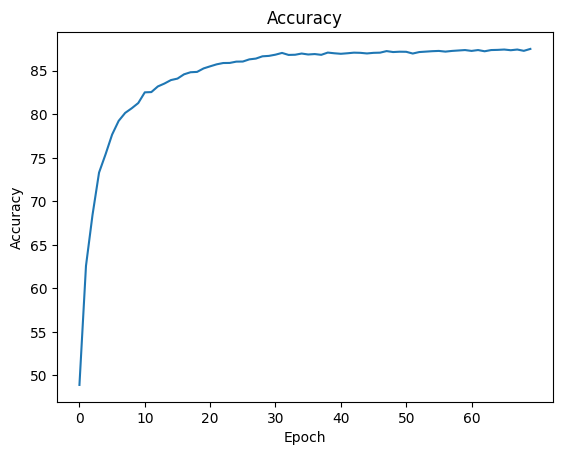

In [9]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

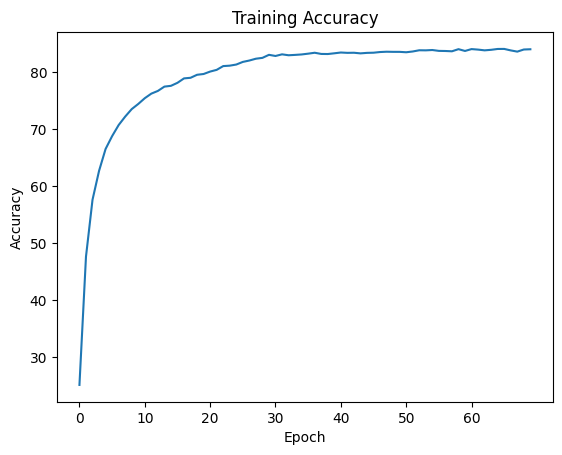

In [10]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()

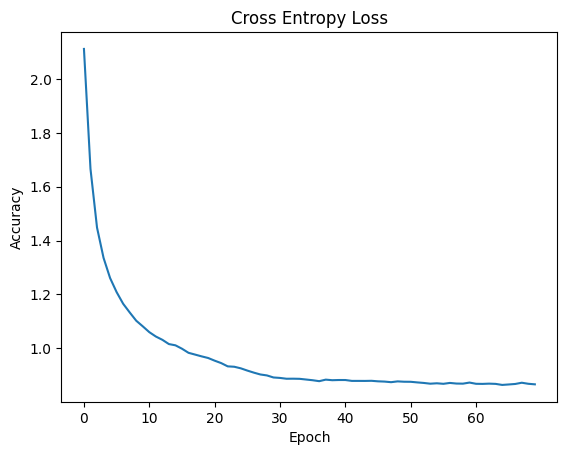

In [11]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,70,10))
plt.ylabel('Accuracy')
plt.show()